### 아래 모듈 설치 필요함

In [1]:
# !pip install pytorch-forecasting

In [2]:
import pytorch_forecasting
print("pytorch_forecasting 버전:", pytorch_forecasting.__version__)

pytorch_forecasting 버전: 1.3.0


/Users/hdj/miniforge3/envs/kf_proj/lib/python3.10/site-packages/pytorch_forecasting/models/base_model.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [3]:
import os
import numpy as np
import pandas as pd
import re
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

from collections import defaultdict

from pytorch_forecasting.data.encoders import NaNLabelEncoder
from pytorch_forecasting import TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.metrics.base_metrics import Metric as PFMetric
from pytorch_forecasting.metrics import CrossEntropy

import lightning.pytorch as pl
from lightning.pytorch.loggers import TensorBoardLogger
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor, ModelCheckpoint

# 경고 무시 설정
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="matplotlib")
warnings.filterwarnings("ignore", category=UserWarning, module="pytorch_forecasting")

In [4]:
# MPS (Metal Performance Shaders) 사용 가능 여부 확인
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print("Using device:", device)

Using device: mps


### colab file path (각 환경에 맞게 변경 후 사용)

In [5]:
fixed_file_path = "../../dataset/train4a/merged_pedestrian_behavior.csv"

### 새로운 데이터셋으로 merged_pedestrian_behavior.csv 을 생성할 경우 아래 셀들의 주석을 풀어서 실행

In [6]:
# # 보행자 CSV 파일이 저장된 폴더 경로
# data_folder = "../../dataset/train4a"

# # 모든 CSV 파일 찾기
# csv_files = [f for f in os.listdir(data_folder) if f.endswith(".csv")]

# # 숫자 기준으로 파일 정렬 (Video_1_dataset.csv → Video_2_dataset.csv → ...)
# csv_files_sorted = sorted(csv_files, key=lambda x: int(re.search(r"Video_(\d+)_dataset\.csv", x).group(1)) if re.search(r"Video_(\d+)_dataset\.csv", x) else float('inf'))

# # 모든 CSV 파일 로드 및 frame 컬럼 추가
# all_dataframes = []

# print("CSV 파일 로드 시작...")

# for filename in csv_files_sorted:
#     file_path = os.path.join(data_folder, filename)

#     # 파일 로드 로그 출력
#     print(f"처리 중: {filename}")

#     # 파일 이름에서 pedestrian_id 추출 (예: Video_1_dataset.csv → pedestrian_id = 1)
#     match = re.search(r"Video_(\d+)_dataset\.csv", filename)
#     if match:
#         pedestrian_id = int(match.group(1))  # "Video_1_dataset.csv" → 1

#         # CSV 파일 로드
#         df = pd.read_csv(file_path, header=None)  # 컬럼명이 없을 수도 있으므로 header=None 사용

#         # 입력 데이터 (69개)와 행동 라벨 (마지막 열) 분리
#         num_features = 69  # Keypoints(22개) + CoM(3D) = 69차원 입력
#         df_features = df.iloc[:, :num_features]  # 69개 입력 피처
#         df_labels = df.iloc[:, num_features]  # 마지막 열이 행동 클래스 라벨 (0~3)

#         # 컬럼 이름 설정
#         keypoint_columns = [f"kp_{i}" for i in range(num_features)]  # "kp_0", "kp_1", ..., "kp_68"
#         df_features.columns = keypoint_columns  # 입력 피처 이름 지정
#         df_labels.name = "behavior_label"  # 행동 클래스 열 이름 지정

#         # 보행자 ID 추가
#         df_features["pedestrian_id"] = pedestrian_id

#         # 행동 라벨 추가 - 명시적으로 정수형(int)으로 변환
#         df_features["behavior_label"] = df_labels

#         # frame 컬럼 추가 (0부터 시작하는 인덱스)
#         df_features.insert(0, "frame", range(len(df_features)))

#         # 리스트에 저장
#         all_dataframes.append(df_features)

#         # 파일 처리 완료 로그 출력
#         print(f"처리 완료: {filename} (Samples: {len(df_features)})")

# # 모든 데이터를 하나의 DataFrame으로 합침
# full_df = pd.concat(all_dataframes, ignore_index=True)

# # 데이터 타입 확인
# print("\n데이터 타입 확인:")
# for col in ["frame", "pedestrian_id", "behavior_label"]:
#     print(f"{col}: {full_df[col].dtype}")

# # 행동 라벨 분포 확인
# print("\n행동 라벨 분포:")
# print(full_df["behavior_label"].value_counts())

In [7]:
# # 숫자형 데이터만 선택하여 NaN 및 inf 값 확인
# numeric_df = full_df.select_dtypes(include=[np.number])  # 숫자형(float, int) 데이터만 선택

# # NaN(결측값) 개수 확인
# missing_values = numeric_df.isna().sum()
# print("NaN (결측값) 개수:\n", missing_values[missing_values > 0])

# # Inf(무한대) 값 확인
# infinite_values = np.isinf(numeric_df).sum()
# print("\nInf (무한대) 개수:\n", infinite_values[infinite_values > 0])

In [8]:
# # 결측치 제거
# full_df.dropna(inplace=True)
# print("결측값 제거\n")

# # 숫자형 데이터만 선택하여 NaN 및 inf 값 확인
# numeric_df = full_df.select_dtypes(include=[np.number])  # 숫자형(float, int) 데이터만 선택

# # NaN(결측값) 개수 확인
# missing_values = numeric_df.isna().sum()
# print("NaN (결측값) 개수:\n", missing_values[missing_values > 0])

# # Inf(무한대) 값 확인
# infinite_values = np.isinf(numeric_df).sum()
# print("\nInf (무한대) 개수:\n", infinite_values[infinite_values > 0])

In [9]:
# # 정수로 변환
# full_df["behavior_label"] = full_df["behavior_label"].astype(int)

# # 최종 데이터 저장
# full_df.to_csv(fixed_file_path, index=False)

# print("모든 CSV 파일 처리 완료!")
# print(f"최종 데이터 저장: {fixed_file_path}")

### 병합된 csv 파일 load

In [10]:
# 병합된 CSV 데이터 로드
df = pd.read_csv(fixed_file_path)

# 데이터프레임의 컬럼 확인
print("Columns in CSV file:", df.columns)

# 각 컬럼의 데이터 타입 출력
print("데이터 타입 확인:")
print(df.dtypes)

Columns in CSV file: Index(['frame', 'kp_0', 'kp_1', 'kp_2', 'kp_3', 'kp_4', 'kp_5', 'kp_6', 'kp_7',
       'kp_8', 'kp_9', 'kp_10', 'kp_11', 'kp_12', 'kp_13', 'kp_14', 'kp_15',
       'kp_16', 'kp_17', 'kp_18', 'kp_19', 'kp_20', 'kp_21', 'kp_22', 'kp_23',
       'kp_24', 'kp_25', 'kp_26', 'kp_27', 'kp_28', 'kp_29', 'kp_30', 'kp_31',
       'kp_32', 'kp_33', 'kp_34', 'kp_35', 'kp_36', 'kp_37', 'kp_38', 'kp_39',
       'kp_40', 'kp_41', 'kp_42', 'kp_43', 'kp_44', 'kp_45', 'kp_46', 'kp_47',
       'kp_48', 'kp_49', 'kp_50', 'kp_51', 'kp_52', 'kp_53', 'kp_54', 'kp_55',
       'kp_56', 'kp_57', 'kp_58', 'kp_59', 'kp_60', 'kp_61', 'kp_62', 'kp_63',
       'kp_64', 'kp_65', 'kp_66', 'kp_67', 'kp_68', 'pedestrian_id',
       'behavior_label'],
      dtype='object')
데이터 타입 확인:
frame               int64
kp_0              float64
kp_1              float64
kp_2              float64
kp_3              float64
                   ...   
kp_66             float64
kp_67             float64
kp_68       

### 각 포인트의 3차원 좌표 중 z 값이 제외된 2차원 데이터셋도 생성함.

In [11]:

# # Z 좌표를 담고 있는 컬럼들의 인덱스 (kp_2, kp_5, kp_8, ...)
# z_columns = [f'kp_{i}' for i in range(2, 69, 3)]

# # Z 좌표 컬럼 제외
# df_without_z = df.drop(columns=z_columns)

# # 새 CSV 파일로 저장
# output_path = "../../dataset/train4a/merged_pedestrian_behavior_wo_z.csv"
# df_without_z.to_csv(output_path, index=False)

# print(f"Z 좌표가 제외된 데이터가 {output_path}에 저장되었습니다.")
# print(f"원본 컬럼 수: {len(df.columns)}, 제외 후 컬럼 수: {len(df_without_z.columns)}")

### Train, Validation, Test 데이터셋

- 클래스 매핑: 원래 4개의 클래스('Standing', 'Start Walking', 'Walking', 'Finish Walking')에서 2개의 클래스('Standing', 'Walking')로 통합
  - 'Start Walking', 'Walking', 'Finish Walking'을 'Walking' 클래스로 매핑

In [12]:
# Random Seed 고정 (재현성 확보)
torch.manual_seed(42)
torch.cuda.manual_seed(42)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(42)

# pedestrian_id를 문자열로 변환 후 카테고리 타입으로 변환
df["pedestrian_id"] = df["pedestrian_id"].astype(str).astype('category')

# 기존 레이블: Standing(0), Start Walking(1), Walking(2), Finish Walking(3)
# 새 레이블: Standing(0), Walking(1) - Start Walking과 Walking은 Walking으로,
# Standing과 Finish Walking은 Standing으로 처리
df['binary_label'] = df['behavior_label'].apply(lambda x: 1 if x in [1, 2] else 0)

# # 클래스 매핑: 0(Standing)과 1(Walking)로 변환
# # 기존 레이블: Standing(0), Start Walking(1), Walking(2), Finish Walking(3)
# # 새 레이블: Standing(0), Walking(1) - Start Walking, Walking, Finish Walking을 모두 Walking으로 처리
# df['binary_label'] = df['behavior_label'].apply(lambda x: 0 if x == 0 else 1)

# 그룹 정보 생성 - 카테고리 타입을 문자열로 변환 후 연결
df["group"] = df["pedestrian_id"].astype(str) + "_" + df["frame"].astype(str)

# 그룹별 행동 라벨 확인 (각 그룹의 첫 번째 행동 라벨 사용)
group_labels = df.groupby("group")["binary_label"].first().reset_index()

# 그룹을 클래스 비율을 유지하면서 분할 (70% 훈련, 15% 검증, 15% 테스트)
train_groups, temp_groups = train_test_split(
    group_labels["group"],
    test_size=0.3,  # 30%는 validation+test로 사용
    stratify=group_labels["binary_label"],
    random_state=42
)

# 나머지 30%를 검증과 테스트로 절반씩 분할
val_groups, test_groups = train_test_split(
    temp_groups,
    test_size=0.5,  # 15% 테스트, 15% 검증
    stratify=group_labels[group_labels["group"].isin(temp_groups)]["binary_label"],
    random_state=42
)

# 분할된 그룹 목록을 사용하여 훈련, 검증, 테스트 데이터프레임 생성
train_df = df[df["group"].isin(train_groups)].copy()
val_df = df[df["group"].isin(val_groups)].copy()
test_df = df[df["group"].isin(test_groups)].copy()

# 불필요한 'group' 열 제거
train_df = train_df.drop(columns=["group"])
val_df = val_df.drop(columns=["group"])
test_df = test_df.drop(columns=["group"])

print(f"훈련 데이터 크기: {len(train_df)}")
print(f"검증 데이터 크기: {len(val_df)}")
print(f"테스트 데이터 크기: {len(test_df)}")

# 클래스 분포 확인
print("\n훈련 데이터의 클래스 분포:")
print(train_df["binary_label"].value_counts(normalize=True))

print("\n검증 데이터의 클래스 분포:")
print(val_df["binary_label"].value_counts(normalize=True))

print("\n테스트 데이터의 클래스 분포:")
print(test_df["binary_label"].value_counts(normalize=True))

# 시계열 데이터셋 설정
max_encoder_length = 20  # 과거 20 프레임 사용
max_prediction_length = 1  # 현재 행동 예측 (1개 클래스 출력)

# 입력 데이터 (Keypoints + CoM)
feature_columns = [f"kp_{i}" for i in range(69)]  # Keypoints + CoM (69차원)

# NaNLabelEncoder 생성 및 전체 데이터로 학습 (훈련/검증/테스트 모두 동일한 인코더 사용)
pedestrian_encoder = NaNLabelEncoder().fit(df["pedestrian_id"])

# 훈련 데이터셋 생성
train_dataset = TimeSeriesDataSet(
    train_df,
    time_idx="frame",  # 프레임 번호
    target="binary_label",  # 예측할 행동 클래스 (2개)
    group_ids=["pedestrian_id"],  # 보행자별 데이터 그룹화
    max_encoder_length=max_encoder_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["pedestrian_id"],  # 보행자 ID를 Static Variable로 설정
    time_varying_known_reals=["frame"],  # 시간에 따라 변하는 변수
    time_varying_unknown_reals=feature_columns,  # 69차원 입력 데이터
    categorical_encoders={"pedestrian_id": pedestrian_encoder},  # 인코더 명시적 지정
    target_normalizer=None,  # 분류 문제이므로 normalizer 불필요
    allow_missing_timesteps=True,  # 중간 프레임 누락 허용
)

# 검증 데이터셋 생성 (훈련 데이터셋의 설정을 재사용)
val_dataset = TimeSeriesDataSet.from_dataset(
    train_dataset,
    val_df,  # 검증용 데이터
    stop_randomization=True  # 검증 시 랜덤화 비활성화
)

# 테스트 데이터셋 생성 (훈련 데이터셋의 설정을 재사용)
test_dataset = TimeSeriesDataSet.from_dataset(
    train_dataset,
    test_df,  # 테스트용 데이터
    stop_randomization=True  # 테스트 시 랜덤화 비활성화
)

print("TimeSeriesDataSet 생성 완료!")

훈련 데이터 크기: 5491
검증 데이터 크기: 1177
테스트 데이터 크기: 1177

훈련 데이터의 클래스 분포:
binary_label
0    0.547988
1    0.452012
Name: proportion, dtype: float64

검증 데이터의 클래스 분포:
binary_label
0    0.559048
1    0.440952
Name: proportion, dtype: float64

테스트 데이터의 클래스 분포:
binary_label
0    0.536958
1    0.463042
Name: proportion, dtype: float64
TimeSeriesDataSet 생성 완료!


In [13]:
# 데이터로더 생성
batch_size = 32

# 훈련 데이터로더
train_dataloader = train_dataset.to_dataloader(
    train=True,
    batch_size=batch_size,
    shuffle=True,
    num_workers=2,
)

# 검증 데이터로더
val_dataloader = val_dataset.to_dataloader(
    train=False,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
)

# 테스트 데이터로더
test_dataloader = test_dataset.to_dataloader(
    train=False,
    batch_size=batch_size,
    shuffle=False,
    num_workers=2,
)

print(f"데이터로더 생성 완료 (Train 배치: {len(train_dataloader)}, Val 배치: {len(val_dataloader)}, Test 배치: {len(test_dataloader)})")

데이터로더 생성 완료 (Train 배치: 107, Val 배치: 5, Test 배치: 5)


In [14]:
# 타겟 변수 범위 확인
print("binary_label 고유 값:", np.unique(train_df["binary_label"]))
print("binary_label 최소값:", train_df["binary_label"].min())
print("binary_label 최대값:", train_df["binary_label"].max())

# 데이터 로더 첫 번째 배치 확인
print("\n데이터 로더 확인:")
for batch_idx, batch in enumerate(train_dataloader):
    x, y = batch

    if isinstance(y, (list, tuple)) and len(y) > 0:
        y_sample = y[0]
        print(f"타겟 형상: {y_sample.shape}")
        print(f"타겟 데이터 타입: {y_sample.dtype}")
        print(f"타겟 고유 값: {torch.unique(y_sample)}")
        print(f"타겟 최소값: {y_sample.min()}")
        print(f"타겟 최대값: {y_sample.max()}")
    else:
        print(f"타겟 형상: {y.shape}")
        print(f"타겟 데이터 타입: {y.dtype}")
        print(f"타겟 고유 값: {torch.unique(y)}")
        print(f"타겟 최소값: {y.min()}")
        print(f"타겟 최대값: {y.max()}")

    break  # 첫 번째 배치만 확인

binary_label 고유 값: [0 1]
binary_label 최소값: 0
binary_label 최대값: 1

데이터 로더 확인:
타겟 형상: torch.Size([32, 1])
타겟 데이터 타입: torch.int64
타겟 고유 값: tensor([0, 1])
타겟 최소값: 0
타겟 최대값: 1


In [15]:
# BCE Loss 구현 (PyTorch Forecasting 메트릭 시스템과 호환)
class BCEWithLogitsLoss(PFMetric):
    """
    Binary Cross Entropy Loss for binary classification in time series forecasting.
    Compatible with pytorch_forecasting metric system.

    Args:
        reduction: reduction to apply to the output ("none"|"mean"|"sum") (default: "mean")
        weight: optional weighting factor for class imbalance (default: None)
        pos_weight: optional weight for positive examples (default: None)
        prediction_length: prediction length (default: 1)
    """
    def __init__(
        self,
        reduction: str = "mean",
        weight: torch.Tensor = None,
        pos_weight: torch.Tensor = None,
        prediction_length: int = 1,
        **kwargs
    ):
        super().__init__(reduction=reduction, **kwargs)
        self.prediction_length = prediction_length

        # 클래스 가중치 설정
        if weight is not None:
            self.register_buffer("weight", weight)
        else:
            self.weight = None

        # 양성 클래스 가중치 설정
        if pos_weight is not None:
            self.register_buffer("pos_weight", pos_weight)
        else:
            self.pos_weight = None

    def loss(self, y_pred, y_actual):
        """
        Calculate binary cross entropy loss with logits.

        Args:
            y_pred: network prediction tensor of shape [batch_size, ..., n_classes]
            y_actual: actual values of shape [batch_size, ...] or tuple of tensors

        Returns:
            torch.Tensor: loss
        """
        # 타겟 처리 - 튜플인 경우 첫 번째 요소 사용
        if isinstance(y_actual, tuple):
            y_actual = y_actual[0]  # 첫 번째 요소 사용

        # 타겟 차원 조정
        if y_actual.dim() > 1 and y_actual.size(-1) == 1:
            y_actual = y_actual.squeeze(-1)

        # 예측 텐서 형태 조정 (이진 분류이므로 클래스 수는 2)
        if y_pred.ndim > 2:
            y_pred = y_pred.reshape(-1, y_pred.size(-1))

        # 2클래스 로짓에서 단일 로짓으로 변환 (클래스 1의 로짓 사용)
        if y_pred.size(-1) == 2:
            y_pred = y_pred[:, 1]  # 클래스 1(Walking)의 로짓 사용

        # 타겟 텐서도 동일하게 조정
        y_actual = y_actual.reshape(-1).float()  # 부동소수점으로 변환

        # BCEWithLogitsLoss 계산
        loss = F.binary_cross_entropy_with_logits(
            y_pred,
            y_actual,
            weight=self.weight,
            pos_weight=self.pos_weight,
            reduction=self.reduction
        )

        return loss

    def to_prediction(self, y_actual):
        """
        Convert target tensor to the right format.

        Args:
            y_actual: actual values (tensor or tuple)

        Returns:
            torch.Tensor: transformed tensor
        """
        # 튜플인 경우 첫 번째 요소 사용
        if isinstance(y_actual, tuple):
            y_actual = y_actual[0]

        # 다차원 텐서 처리
        if y_actual.ndim > 2:
            y_actual = y_actual.reshape(-1, y_actual.size(-1))

        # 마지막 차원이 1인 경우 제거
        if y_actual.size(-1) == 1:
            y_actual = y_actual.squeeze(-1)

        return y_actual

    def to_quantiles(self, y_pred):
        """
        Convert network prediction to quantiles.
        Not relevant for classification but required by the interface.

        Args:
            y_pred: prediction output of network

        Returns:
            torch.Tensor: prediction
        """
        return y_pred

    def update(self, y_pred, y_actual):
        """
        Update metric state with predictions and targets.
        Required by the interface.

        Args:
            y_pred: predictions from model
            y_actual: actual values
        """
        # 손실 계산
        loss = self.loss(y_pred, y_actual)
        self.val = loss  # 현재 손실 값 저장

    def compute(self):
        """
        Compute the metric.
        Required by the interface.

        Returns:
            torch.Tensor: metric value
        """
        return self.val

In [16]:
# 정확도 계산 콜백
class AccuracyCallback(pl.Callback):
    def __init__(self):
        super().__init__()
        self.train_accs = []
        self.val_accs = []
        self.train_losses = []
        self.val_losses = []

    def on_train_epoch_end(self, trainer, pl_module):
        # 훈련 손실 기록
        train_loss = trainer.callback_metrics.get("train_loss")
        if train_loss is not None:
            self.train_losses.append(train_loss.item())

        # 훈련 정확도 계산
        train_acc = self.calculate_accuracy(pl_module, train_dataloader, max_batches=5)
        self.train_accs.append(train_acc)
        print(f"Epoch {trainer.current_epoch}: Train Acc = {train_acc:.4f}")

    def on_validation_epoch_end(self, trainer, pl_module):
        # 검증 손실 기록
        val_loss = trainer.callback_metrics.get("val_loss")
        if val_loss is not None:
            self.val_losses.append(val_loss.item())

        # 검증 정확도 계산
        val_acc = self.calculate_accuracy(pl_module, val_dataloader)
        self.val_accs.append(val_acc)
        print(f"Epoch {trainer.current_epoch}: Valid Acc = {val_acc:.4f}")

    def calculate_accuracy(self, model, dataloader, max_batches=None):
        """scikit-learn을 사용한 정확도 계산"""
        model.eval()
        all_predictions = []
        all_targets = []
        device = next(model.parameters()).device

        with torch.no_grad():
            for batch_idx, batch in enumerate(dataloader):
                if max_batches is not None and batch_idx >= max_batches:
                    break

                x, y = batch

                # 입력 데이터 장치 이동
                if isinstance(x, dict):
                    for k in x:
                        if isinstance(x[k], torch.Tensor):
                            x[k] = x[k].to(device)
                else:
                    x = x.to(device)

                # 예측 수행
                outputs = model(x)
                if isinstance(outputs, tuple):
                    outputs = outputs[0]

                # 이진 분류 처리 - 클래스가 2개이면 0.5 기준으로 이항 분류
                if outputs.size(-1) == 2:
                    _, predictions = torch.max(outputs, dim=-1)
                else:  # 단일 로짓이면 0.5 임계값으로 클래스 결정
                    predictions = (torch.sigmoid(outputs) > 0.5).long()

                # 타겟값 처리
                if isinstance(y, (list, tuple)) and len(y) > 0:
                    y = y[0]

                if y.dim() > 1:
                    if y.dim() == 2 and y.size(1) == 1:
                        y = y.squeeze(1)
                    elif y.dim() == 3:
                        if y.size(1) == 1 and y.size(2) == 1:
                            y = y.squeeze()
                        else:
                            y = y[:, 0, 0]

                # NumPy 배열로 변환
                all_predictions.extend(predictions.cpu().numpy())
                all_targets.extend(y.cpu().numpy())

        model.train()

        # scikit-learn의 accuracy_score 사용
        return accuracy_score(all_targets, all_predictions)

    def plot_metrics(self, save_path=None):
        """메트릭 그래프 그리기"""
        plt.figure(figsize=(16, 6))

        # 손실 그래프
        plt.subplot(1, 2, 1)
        if len(self.train_losses) > 0:
            plt.plot(self.train_losses, 'r-o', label='Train Loss')
        if len(self.val_losses) > 0:
            plt.plot(self.val_losses, 'b-s', label='Valid Loss')
        plt.title('Loss History')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.grid(True)
        plt.legend()

        # 정확도 그래프
        plt.subplot(1, 2, 2)
        if len(self.train_accs) > 0:
            plt.plot(self.train_accs, 'r-', label='Train Acc.')
        if len(self.val_accs) > 0:
            plt.plot(self.val_accs, 'b-x', label='Valid Acc.')
        plt.title('Accuracy History')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.grid(True)
        plt.legend()
        plt.ylim(0.0, 1.0)

        plt.tight_layout()
        if save_path:
            plt.savefig(save_path)
        plt.show()

        # 정확도 값 출력
        print("훈련 정확도:", self.train_accs)
        print("검증 정확도:", self.val_accs)


In [17]:
# 커스텀 TFT 클래스 정의 (시각화 오류 우회)
class CustomTFT(TemporalFusionTransformer):
    def log_prediction(self, x, out, batch_idx, **kwargs):
        # 시각화 없이 빈 로그 반환
        return {}

In [18]:
# 모델 저장 경로 설정
checkpoint_dir = '../../Model/TFT_2_class'
if not os.path.exists(checkpoint_dir):
    os.makedirs(checkpoint_dir)

In [19]:
# BCE Loss 인스턴스 생성 (클래스 불균형이 있는 경우 pos_weight 값을 조정할 수 있음)
# pos_weight는 양성 클래스(Walking)의 가중치
pos_weight = None  # 클래스 불균형이 거의 없다면 None으로 설정

# 이진 분류를 위한 BCE Loss 생성
bce_loss = BCEWithLogitsLoss(pos_weight=pos_weight)

# TFT 모델 생성 (출력 크기를 2로 설정 - 이진 분류용)
tft = CustomTFT.from_dataset(
    train_dataset,
    hidden_size=32,
    lstm_layers=2,
    attention_head_size=4,
    dropout=0.5,
    hidden_continuous_size=16,
    output_size=2,  # 이진 분류(Standing/Walking)
    loss=bce_loss,
    learning_rate=0.0001,
    log_interval=50,
    reduce_on_plateau_patience=5
)

print(f"모델 파라미터 수: {tft.size()/1e3:.1f}k")

모델 파라미터 수: 242.8k


/Users/hdj/miniforge3/envs/kf_proj/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/hdj/miniforge3/envs/kf_proj/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.


In [20]:
# 콜백 설정
# 조기 종료 콜백
early_stop_callback = EarlyStopping(
    monitor="val_loss",
    min_delta=1e-4,
    patience=100,
    verbose=True,
    mode="min"
)

# 학습률 모니터링 콜백
lr_logger = LearningRateMonitor()

# 모델 체크포인트 콜백
checkpoint_callback = ModelCheckpoint(
    dirpath=checkpoint_dir,
    filename="tft-pedestrian-binary-{epoch:02d}-{val_loss:.4f}",
    monitor="val_loss",
    save_top_k=1,
    mode="min"
)

In [21]:
# 정확도 콜백 인스턴스 생성
accuracy_callback = AccuracyCallback()

# 트레이너 설정에 메트릭 콜백 추가
trainer = pl.Trainer(
    max_epochs=300,
    accelerator="auto",
    gradient_clip_val=0.1,
    callbacks=[lr_logger, early_stop_callback, checkpoint_callback, accuracy_callback],
    logger=TensorBoardLogger(checkpoint_dir, name="pedestrian_tft_binary_logs"),
    enable_progress_bar=True,
    log_every_n_steps=50,
    num_sanity_val_steps=0
)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


/Users/hdj/miniforge3/envs/kf_proj/lib/python3.10/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:654: Checkpoint directory /Users/hdj/study/MODU/AIFFELTHON/Model/TFT_2_class exists and is not empty.

   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | BCEWithLogitsLoss               | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 533    | train
3  | prescalers                         | ModuleDict                      | 2.2 K  | train
4  | static_variable_selection          | VariableSelectionNetwork        | 96     | train
5  | encoder_variable_selection         | VariableSelectionNetwork        | 170 K  | train
6  | decoder_variable_selection         | VariableS

Epoch 0: 100%|██████████| 107/107 [00:56<00:00,  1.90it/s, v_num=6, train_loss_step=0.674, val_loss=0.675, train_loss_epoch=0.711]

Metric val_loss improved. New best score: 0.675


Epoch 1: 100%|██████████| 107/107 [01:00<00:00,  1.76it/s, v_num=6, train_loss_step=0.707, val_loss=0.652, train_loss_epoch=0.685]

Metric val_loss improved by 0.023 >= min_delta = 0.0001. New best score: 0.652


Epoch 2: 100%|██████████| 107/107 [01:00<00:00,  1.78it/s, v_num=6, train_loss_step=0.706, val_loss=0.617, train_loss_epoch=0.666]

Metric val_loss improved by 0.034 >= min_delta = 0.0001. New best score: 0.617


Epoch 3: 100%|██████████| 107/107 [00:59<00:00,  1.79it/s, v_num=6, train_loss_step=0.596, val_loss=0.592, train_loss_epoch=0.641]

Metric val_loss improved by 0.025 >= min_delta = 0.0001. New best score: 0.592


Epoch 4: 100%|██████████| 107/107 [01:00<00:00,  1.78it/s, v_num=6, train_loss_step=0.504, val_loss=0.570, train_loss_epoch=0.595]

Metric val_loss improved by 0.023 >= min_delta = 0.0001. New best score: 0.570


Epoch 5: 100%|██████████| 107/107 [01:00<00:00,  1.78it/s, v_num=6, train_loss_step=0.502, val_loss=0.538, train_loss_epoch=0.543]

Metric val_loss improved by 0.032 >= min_delta = 0.0001. New best score: 0.538


Epoch 6: 100%|██████████| 107/107 [01:00<00:00,  1.77it/s, v_num=6, train_loss_step=0.554, val_loss=0.521, train_loss_epoch=0.506]

Metric val_loss improved by 0.017 >= min_delta = 0.0001. New best score: 0.521


Epoch 7: 100%|██████████| 107/107 [00:59<00:00,  1.79it/s, v_num=6, train_loss_step=0.491, val_loss=0.511, train_loss_epoch=0.464]

Metric val_loss improved by 0.010 >= min_delta = 0.0001. New best score: 0.511


Epoch 9: 100%|██████████| 107/107 [01:00<00:00,  1.77it/s, v_num=6, train_loss_step=0.283, val_loss=0.491, train_loss_epoch=0.425]

Metric val_loss improved by 0.019 >= min_delta = 0.0001. New best score: 0.491


Epoch 13: 100%|██████████| 107/107 [00:59<00:00,  1.80it/s, v_num=6, train_loss_step=0.379, val_loss=0.488, train_loss_epoch=0.383]

Metric val_loss improved by 0.003 >= min_delta = 0.0001. New best score: 0.488


Epoch 19: 100%|██████████| 107/107 [01:01<00:00,  1.73it/s, v_num=6, train_loss_step=0.393, val_loss=0.457, train_loss_epoch=0.342]

Metric val_loss improved by 0.031 >= min_delta = 0.0001. New best score: 0.457


Epoch 22: 100%|██████████| 107/107 [01:02<00:00,  1.71it/s, v_num=6, train_loss_step=0.477, val_loss=0.444, train_loss_epoch=0.325]

Metric val_loss improved by 0.012 >= min_delta = 0.0001. New best score: 0.444


Epoch 24: 100%|██████████| 107/107 [01:00<00:00,  1.77it/s, v_num=6, train_loss_step=0.368, val_loss=0.437, train_loss_epoch=0.301]

Metric val_loss improved by 0.008 >= min_delta = 0.0001. New best score: 0.437


Epoch 29: 100%|██████████| 107/107 [01:03<00:00,  1.69it/s, v_num=6, train_loss_step=0.243, val_loss=0.425, train_loss_epoch=0.264]

Metric val_loss improved by 0.012 >= min_delta = 0.0001. New best score: 0.425


Epoch 30: 100%|██████████| 107/107 [01:03<00:00,  1.68it/s, v_num=6, train_loss_step=0.504, val_loss=0.398, train_loss_epoch=0.256]

Metric val_loss improved by 0.026 >= min_delta = 0.0001. New best score: 0.398


Epoch 33: 100%|██████████| 107/107 [01:00<00:00,  1.78it/s, v_num=6, train_loss_step=0.396, val_loss=0.396, train_loss_epoch=0.259]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.396


Epoch 35: 100%|██████████| 107/107 [01:00<00:00,  1.77it/s, v_num=6, train_loss_step=0.201, val_loss=0.394, train_loss_epoch=0.255]

Metric val_loss improved by 0.002 >= min_delta = 0.0001. New best score: 0.394


Epoch 69: 100%|██████████| 107/107 [01:05<00:00,  1.63it/s, v_num=6, train_loss_step=0.241, val_loss=0.382, train_loss_epoch=0.181]

Metric val_loss improved by 0.012 >= min_delta = 0.0001. New best score: 0.382


Epoch 109: 100%|██████████| 107/107 [01:04<00:00,  1.67it/s, v_num=6, train_loss_step=0.147, val_loss=0.374, train_loss_epoch=0.176]

Metric val_loss improved by 0.007 >= min_delta = 0.0001. New best score: 0.374


Epoch 110: 100%|██████████| 107/107 [01:02<00:00,  1.70it/s, v_num=6, train_loss_step=0.207, val_loss=0.363, train_loss_epoch=0.169]

Metric val_loss improved by 0.011 >= min_delta = 0.0001. New best score: 0.363


Epoch 210: 100%|██████████| 107/107 [01:00<00:00,  1.76it/s, v_num=6, train_loss_step=0.137, val_loss=0.411, train_loss_epoch=0.137]

Monitored metric val_loss did not improve in the last 100 records. Best score: 0.363. Signaling Trainer to stop.


Epoch 210: 100%|██████████| 107/107 [01:01<00:00,  1.74it/s, v_num=6, train_loss_step=0.137, val_loss=0.411, train_loss_epoch=0.137]
모델 학습 완료!


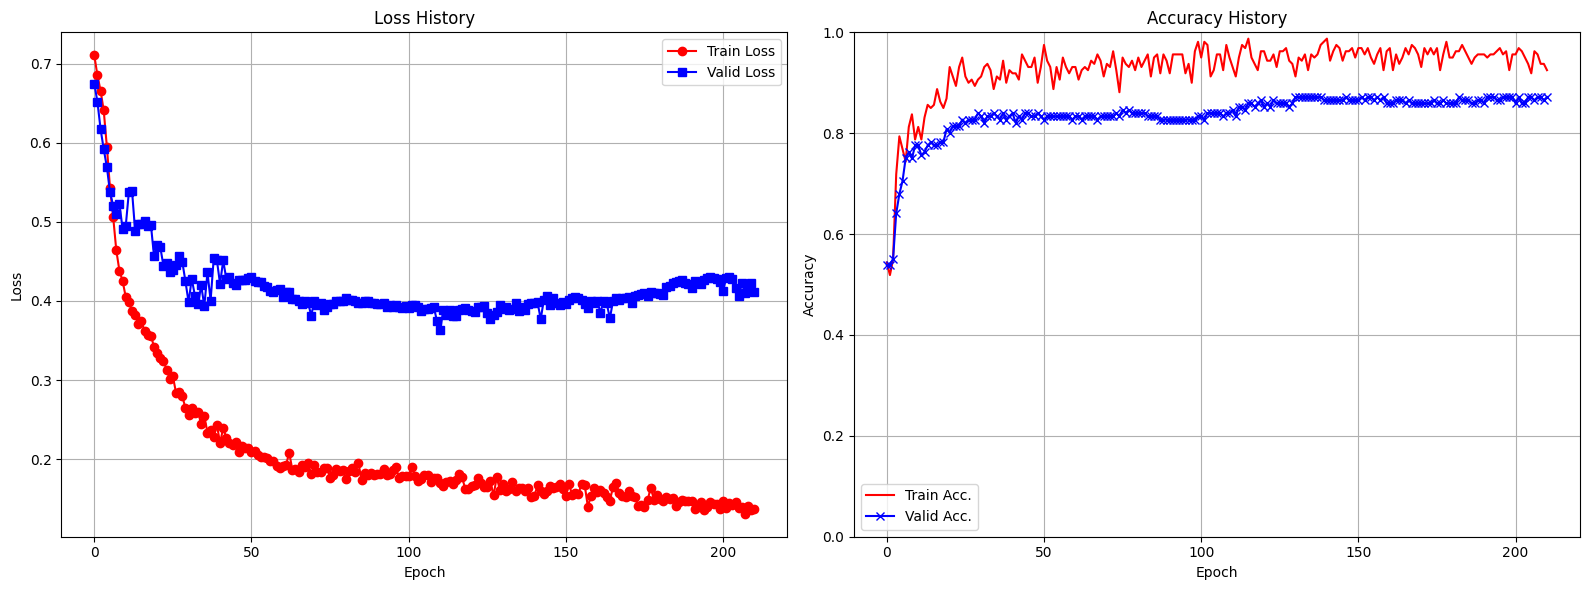

훈련 정확도: [0.54375, 0.51875, 0.55, 0.71875, 0.79375, 0.76875, 0.74375, 0.8125, 0.8375, 0.7875, 0.8125, 0.7875, 0.83125, 0.85625, 0.85, 0.85625, 0.8875, 0.8625, 0.85, 0.86875, 0.93125, 0.9125, 0.89375, 0.93125, 0.95, 0.9125, 0.9, 0.90625, 0.89375, 0.90625, 0.9125, 0.93125, 0.9375, 0.925, 0.8875, 0.9125, 0.90625, 0.94375, 0.9, 0.925, 0.91875, 0.91875, 0.90625, 0.95625, 0.94375, 0.93125, 0.93125, 0.95, 0.9, 0.93125, 0.975, 0.94375, 0.93125, 0.8875, 0.93125, 0.90625, 0.95, 0.93125, 0.91875, 0.93125, 0.93125, 0.90625, 0.925, 0.93125, 0.925, 0.94375, 0.9375, 0.95625, 0.94375, 0.9125, 0.9375, 0.93125, 0.9625, 0.925, 0.88125, 0.95, 0.9375, 0.93125, 0.94375, 0.925, 0.95, 0.93125, 0.94375, 0.95625, 0.9125, 0.95, 0.95625, 0.91875, 0.95625, 0.94375, 0.91875, 0.95625, 0.95625, 0.95625, 0.95625, 0.91875, 0.9375, 0.9, 0.9625, 0.98125, 0.95, 0.98125, 0.975, 0.9125, 0.925, 0.95625, 0.95625, 0.925, 0.975, 0.95, 0.93125, 0.9125, 0.95, 0.975, 0.96875, 0.9875, 0.95, 0.9375, 0.925, 0.9625, 0.9625, 0.94375, 0.

In [22]:
# 학습 실행
try:
    trainer.fit(
        tft,
        train_dataloaders=train_dataloader,
        val_dataloaders=val_dataloader,
    )
    print("모델 학습 완료!")

    # 그래프 그리기
    accuracy_callback.plot_metrics(save_path=os.path.join(checkpoint_dir, 'training_history.png'))

except Exception as e:
    print(f"학습 중 오류 발생: {e}")
    import traceback
    traceback.print_exc()

사용 장치: mps


/Users/hdj/miniforge3/envs/kf_proj/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
/Users/hdj/miniforge3/envs/kf_proj/lib/python3.10/site-packages/lightning/pytorch/utilities/parsing.py:209: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.



분류 보고서:
              precision    recall  f1-score   support

    Standing       0.86      0.86      0.86        86
     Walking       0.83      0.83      0.83        70

    accuracy                           0.85       156
   macro avg       0.84      0.84      0.84       156
weighted avg       0.85      0.85      0.85       156



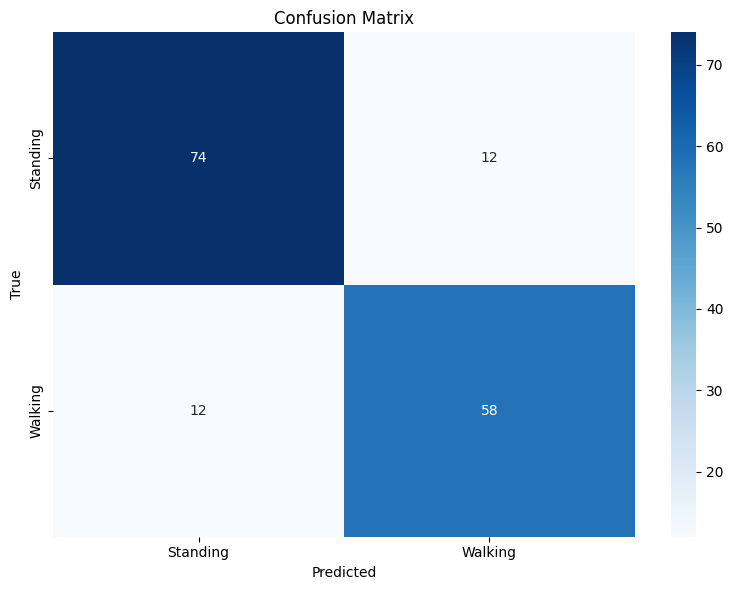

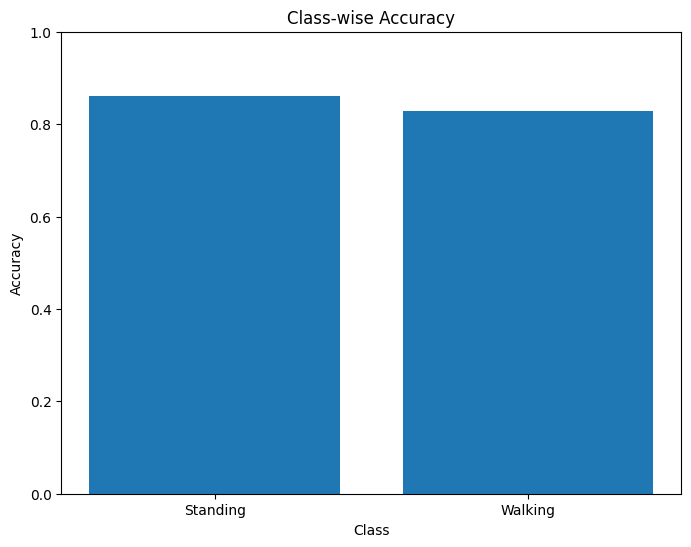

모델 평가 및 시각화 완료!


In [23]:
# 평가 및 시각화 (학습 성공 시)
try:
    # 학습이 성공적으로 완료되면 최고 성능 모델 로드
    best_model_path = checkpoint_callback.best_model_path
    if os.path.exists(best_model_path):
        print(f"사용 장치: {device}")

        # 모델 로드 시 장치 명시
        best_tft = TemporalFusionTransformer.load_from_checkpoint(
            best_model_path,
            map_location=device
        )
        best_tft.to(device)  # 명시적으로 모델을 장치로 이동
        best_tft.eval()  # 평가 모드로 전환

        # 검증 데이터에 대한 예측 및 평가
        val_predictions = []
        val_targets = []

        for batch in val_dataloader:
            x, y = batch

            # 데이터를 모델과 동일한 장치로 이동
            if isinstance(x, dict):
                # 딕셔너리인 경우 각 텐서를 이동
                for k in x:
                    if isinstance(x[k], torch.Tensor):
                        x[k] = x[k].to(device)
            else:
                x = x.to(device)

            if isinstance(y, (list, tuple)) and len(y) > 0:
                y = [yi.to(device) for yi in y if isinstance(yi, torch.Tensor)]
            elif isinstance(y, torch.Tensor):
                y = y.to(device)

            with torch.no_grad():
                predictions = best_tft(x)

            # 예측값 처리
            if isinstance(predictions, tuple):
                predictions = predictions[0]

            # 이진 분류 처리
            if predictions.size(-1) == 2:
                pred_labels = predictions.argmax(dim=-1).cpu().numpy()
            else:
                pred_labels = (torch.sigmoid(predictions) > 0.5).long().cpu().numpy()

            # 타겟값 처리 - 일관된 차원 처리
            if isinstance(y, (list, tuple)) and len(y) > 0:
                y = y[0]

            # 타겟값 형태 수정
            if y.dim() > 1:
                if y.dim() == 2:
                    # [batch_size, 1] 형태인 경우
                    if y.size(1) == 1:
                        y = y.squeeze(1)
                elif y.dim() == 3:
                    # [batch_size, 1, 1] 형태인 경우
                    if y.size(1) == 1 and y.size(2) == 1:
                        y = y.squeeze()
                    else:
                        # 다른 3차원 형태의 경우, 첫 번째 값만 사용
                        y = y[:, 0, 0]

            targets = y.cpu().long().numpy()

            val_predictions.extend(pred_labels)
            val_targets.extend(targets)

        # 분류 보고서
        print("\n분류 보고서:")
        report = classification_report(
            val_targets,
            val_predictions,
            target_names=['Standing', 'Walking']
        )
        print(report)

        # 혼동 행렬 시각화
        try:
            plt.figure(figsize=(8, 6))
            cm = confusion_matrix(val_targets, val_predictions)
            sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                      xticklabels=['Standing', 'Walking'],
                      yticklabels=['Standing', 'Walking'])
            plt.xlabel('Predicted')
            plt.ylabel('True')
            plt.title('Confusion Matrix')
            plt.tight_layout()
            plt.savefig(os.path.join(checkpoint_dir, 'confusion_matrix.png'))
            plt.show()

            # 클래스별 정확도 계산 및 시각화
            class_accuracy = np.zeros(2)  # 0~1 클래스에 대한 정확도 배열 초기화
            for i in range(min(2, len(cm))):
                if cm.sum(axis=1)[i] > 0:  # 0으로 나누기 방지
                    class_accuracy[i] = cm[i, i] / cm.sum(axis=1)[i]

            plt.figure(figsize=(8, 6))
            plt.bar(['Standing', 'Walking'], class_accuracy)
            plt.xlabel('Class')
            plt.ylabel('Accuracy')
            plt.title('Class-wise Accuracy')
            plt.ylim(0, 1)
            plt.savefig(os.path.join(checkpoint_dir, 'class_accuracy.png'))
            plt.show()
        except Exception as e:
            print(f"시각화 중 오류 발생: {e}")
            import traceback
            traceback.print_exc()
    else:
        print(f"최고 성능 모델 파일을 찾을 수 없습니다: {best_model_path}")
except Exception as e:
    print(f"평가 중 오류 발생: {e}")
    import traceback
    traceback.print_exc()

print("모델 평가 및 시각화 완료!")

In [24]:
# 테스트 데이터에 대한 예측 및 평가
test_predictions = []
test_targets = []

for batch in test_dataloader:
    x, y = batch

    # 데이터를 모델과 동일한 장치로 이동
    if isinstance(x, dict):
        for k in x:
            if isinstance(x[k], torch.Tensor):
                x[k] = x[k].to(device)
    else:
        x = x.to(device)

    with torch.no_grad():
        predictions = best_tft(x)

    # 예측값 처리
    if isinstance(predictions, tuple):
        predictions = predictions[0]

    # 이진 분류 처리
    if predictions.size(-1) == 2:
        pred_labels = predictions.argmax(dim=-1).cpu().numpy()
    else:
        pred_labels = (torch.sigmoid(predictions) > 0.5).long().cpu().numpy()

    # 타겟값 처리
    if isinstance(y, (list, tuple)) and len(y) > 0:
        y = y[0]

    # 타겟값 형태 수정
    if y.dim() > 1:
        if y.dim() == 2 and y.size(1) == 1:
            y = y.squeeze(1)
        elif y.dim() == 3:
            if y.size(1) == 1 and y.size(2) == 1:
                y = y.squeeze()
            else:
                y = y[:, 0, 0]

    targets = y.cpu().numpy()

    test_predictions.extend(pred_labels)
    test_targets.extend(targets)

# 행동 클래스 레이블
behavior_labels = ['Standing', 'Walking']

# 분류 보고서
print("\n테스트 데이터 분류 보고서:")
report = classification_report(
    test_targets,
    test_predictions,
    target_names=behavior_labels
)
print(report)


테스트 데이터 분류 보고서:
              precision    recall  f1-score   support

    Standing       0.87      0.92      0.90        75
     Walking       0.92      0.87      0.89        78

    accuracy                           0.90       153
   macro avg       0.90      0.90      0.90       153
weighted avg       0.90      0.90      0.90       153



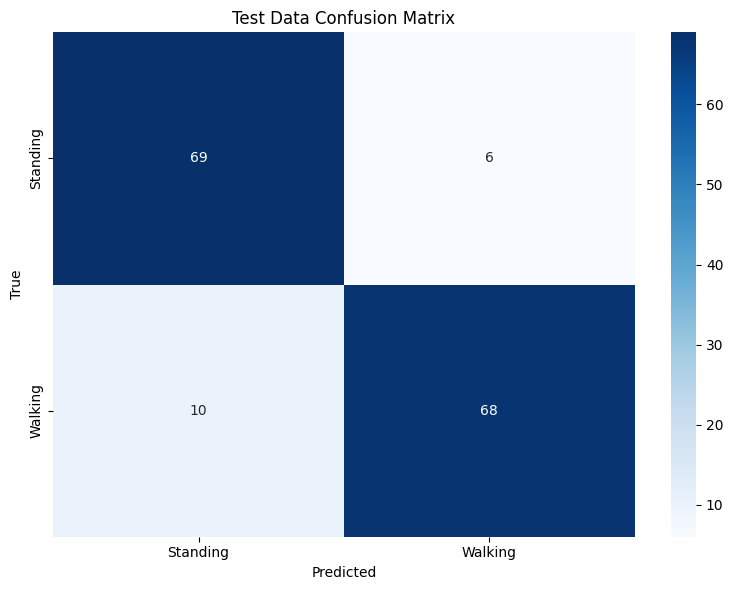

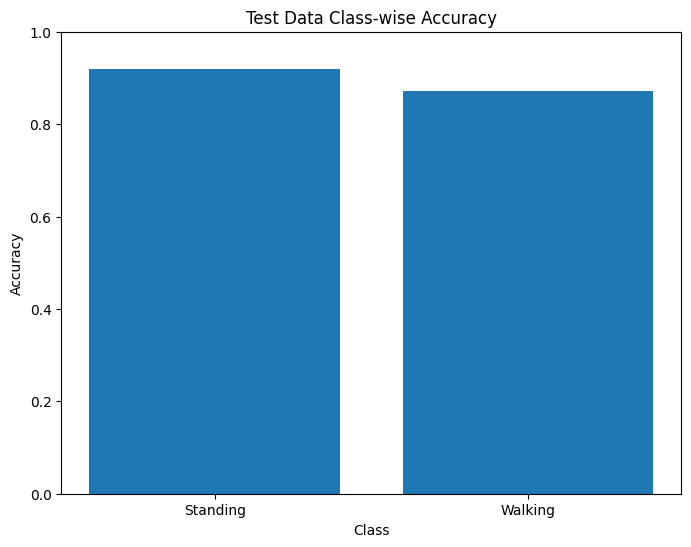


테스트 전체 정확도: 0.8954


In [25]:
# 혼동 행렬 계산 및 시각화
cm = confusion_matrix(test_targets, test_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
           xticklabels=behavior_labels,
           yticklabels=behavior_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Test Data Confusion Matrix')
plt.tight_layout()
plt.savefig(os.path.join(checkpoint_dir, 'test_confusion_matrix.png'))
plt.show()

# 클래스별 정확도 계산 및 시각화
class_accuracy = np.zeros(2)
for i in range(min(2, len(cm))):
    if cm.sum(axis=1)[i] > 0:
        class_accuracy[i] = cm[i, i] / cm.sum(axis=1)[i]

plt.figure(figsize=(8, 6))
plt.bar(behavior_labels, class_accuracy)
plt.xlabel('Class')
plt.ylabel('Accuracy')
plt.title('Test Data Class-wise Accuracy')
plt.ylim(0, 1)
plt.savefig(os.path.join(checkpoint_dir, 'test_class_accuracy.png'))
plt.show()

# 전체 정확도 계산
test_accuracy = accuracy_score(test_targets, test_predictions)
print(f"\n테스트 전체 정확도: {test_accuracy:.4f}")

In [26]:
# 클래스 분포 비교
print("검증 데이터 클래스 분포:")
print(val_df["binary_label"].value_counts(normalize=True))

print("\n테스트 데이터 클래스 분포:")
print(test_df["binary_label"].value_counts(normalize=True))

# 각 데이터셋의 특성 통계 확인
def show_feature_stats(df, name):
    feature_cols = [col for col in df.columns if col.startswith('kp_')]
    feature_means = df[feature_cols].mean()
    feature_stds = df[feature_cols].std()
    print(f"\n{name} 데이터 특성 통계")
    for i in range(23):
        print(f"kp_{i}: 평균={feature_means[f'kp_{i}']:.4f}, 표준편차={feature_stds[f'kp_{i}']:.4f}")

show_feature_stats(val_df, "검증")
show_feature_stats(test_df, "테스트")

검증 데이터 클래스 분포:
binary_label
0    0.559048
1    0.440952
Name: proportion, dtype: float64

테스트 데이터 클래스 분포:
binary_label
0    0.536958
1    0.463042
Name: proportion, dtype: float64

검증 데이터 특성 통계
kp_0: 평균=0.2005, 표준편차=0.0314
kp_1: 평균=0.0186, 표준편차=0.0482
kp_2: 평균=0.0418, 표준편차=0.0186
kp_3: 평균=0.0529, 표준편차=0.0229
kp_4: 평균=0.0239, 표준편차=0.0468
kp_5: 평균=0.0388, 표준편차=0.0183
kp_6: 평균=0.2271, 표준편차=0.0304
kp_7: 평균=0.2055, 표준편차=0.0375
kp_8: 평균=0.0420, 표준편차=0.0198
kp_9: 평균=0.0352, 표준편차=0.0307
kp_10: 평균=0.2005, 표준편차=0.0295
kp_11: 평균=0.0431, 표준편차=0.0190
kp_12: 평균=0.2155, 표준편차=0.0432
kp_13: 평균=0.2080, 표준편차=0.0743
kp_14: 평균=0.1079, 표준편차=0.0149
kp_15: 평균=0.0282, 표준편차=0.0449
kp_16: 평균=0.2105, 표준편차=0.0797
kp_17: 평균=0.1029, 표준편차=0.0172
kp_18: 평균=0.2138, 표준편차=0.0509
kp_19: 평균=0.2119, 표준편차=0.0936
kp_20: 평균=0.1279, 표준편차=0.0144
kp_21: 평균=0.0235, 표준편차=0.0533
kp_22: 평균=0.2148, 표준편차=0.1007

테스트 데이터 특성 통계
kp_0: 평균=0.2014, 표준편차=0.0281
kp_1: 평균=0.0191, 표준편차=0.0472
kp_2: 평균=0.0415, 표준편차=0.0183
kp_3: 평균=0.0517, 표준편차=0.